In [1]:
#pip install labelme albumentations

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
from tensorflow import keras
import time
import uuid
import h5py


In [2]:
uuid.uuid1()#creates unique id's

UUID('d99fbc66-ad47-11ef-8a57-9684b016df21')

In [3]:
img_path=os.path.join('data','images')
number_of_img=30

<h2>Review Dataset and Build Image Loading Function</h2>

In [4]:
def captureimg():
    cap=cv2.VideoCapture(0)#cam number
    for imgnum in range(number_of_img):
        print("collecting images {}".format(imgnum))
        ret,frame=cap.read()
        img_name=os.path.join(img_path,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(img_name,frame)
        '''cv2.imwrite()
        method is used to save an image to any storage device. 
        This will save the image according to the specified format
        in current working directory.'''
        #cv2.imshow('frame',frame)
        time.sleep(0.7)#time between vedio capture
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [5]:
#captureimg() #run this only for collecting the images on live

In [6]:
#!labelme
#run this for rectangle pointing after new data collection

In [4]:
import json
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2> Load Image into TF Data Pipeline</h2>

In [5]:
#images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)
images = tf.data.Dataset.list_files('data\\samples\\*.jpg',shuffle=False)
images.as_numpy_iterator().next()


b'data\\samples\\8b8d612c-acc9-11ef-8a8d-9684b016df21.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

<h2> View Raw Images with Matplotlib</h2>

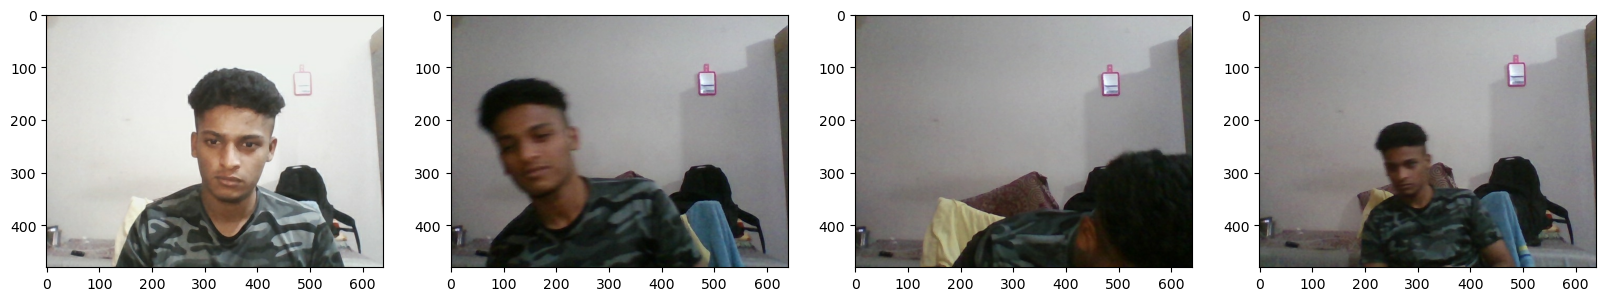

In [8]:
#The tf.data.Dataset.batch() function is used to group the elements into batches.
img_gen=images.batch(4).as_numpy_iterator()#batch of 4
plot_images = img_gen.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

<h1> Partition Unaugmented Data & move mathcing labels</h1>

In [9]:
def move_images():
    import random
    import shutil
    def move_img(src,dest,num):
        files=os.listdir(src)
        files_to_move=random.sample(files,num)

        for file_name in files_to_move:
            src_path=os.path.join(src,file_name)
            dest_path=os.path.join(dest,file_name)
            shutil.move(src_path,dest_path)
            print(f"moved:{file_name}")
    move_img("data/images","data/train/images",48)
    move_img("data/images","data/test/images",6)
    move_img("data/images","data/val/images",6)

In [10]:
#move_images()
#call this to move images

In [11]:
def move_labels():
    for folder in ['train','test','val']:
        for file in os.listdir(os.path.join('data', folder, 'images')):

            filename = file.split('.')[0]+'.json'
            existing_filepath = os.path.join('data','labels', filename)
            if os.path.exists(existing_filepath): 
                new_filepath = os.path.join('data',folder,'labels',filename)
                os.replace(existing_filepath, new_filepath)  

In [10]:
#move_labels()
#call this to move labels to new directorires


<h2>Apply Image Augmentation on Images and Labels using Albumentations</h2>

In [12]:
import albumentations as alb

In [13]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450), 
    alb.HorizontalFlip(p=0.5), 
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2), 
    alb.RGBShift(p=0.2), 
    alb.VerticalFlip(p=0.5)
    ], 
    bbox_params=alb.BboxParams(format='albumentations', 
                                label_fields=['class_labels'])
    )
#refer notes for info about albumentation pipeline

In [14]:
img=cv2.imread(os.path.join('data','train','images','8d575462-acc9-11ef-9327-9684b016df21.jpg'))
img

array([[[136, 140, 164],
        [144, 149, 170],
        [159, 160, 181],
        ...,
        [239, 240, 238],
        [239, 240, 238],
        [239, 240, 238]],

       [[136, 140, 164],
        [145, 150, 171],
        [157, 161, 180],
        ...,
        [239, 240, 238],
        [239, 240, 238],
        [239, 240, 238]],

       [[137, 144, 164],
        [146, 151, 172],
        [158, 162, 181],
        ...,
        [239, 240, 238],
        [239, 240, 238],
        [239, 240, 238]],

       ...,

       [[167, 163, 162],
        [166, 162, 161],
        [165, 163, 162],
        ...,
        [215, 214, 204],
        [214, 213, 203],
        [214, 213, 203]],

       [[162, 157, 158],
        [161, 156, 157],
        [158, 156, 156],
        ...,
        [217, 217, 205],
        [218, 216, 205],
        [219, 217, 206]],

       [[155, 150, 151],
        [153, 148, 149],
        [150, 148, 148],
        ...,
        [220, 220, 208],
        [220, 218, 207],
        [219, 217, 206]]

In [15]:
with open(os.path.join('data','train','labels','8d575462-acc9-11ef-9327-9684b016df21.json'),'r') as f:
    label=json.load(f)

In [13]:
label

{'version': '5.5.0',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[266.75925925925924, 57.59259259259264],
    [482.5, 317.77777777777777]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\8d575462-acc9-11ef-9327-9684b016df21.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8

In [14]:
label['shapes']

[{'label': 'face',
  'points': [[266.75925925925924, 57.59259259259264],
   [482.5, 317.77777777777777]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [15]:
label['shapes'][0]

{'label': 'face',
 'points': [[266.75925925925924, 57.59259259259264],
  [482.5, 317.77777777777777]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {},
 'mask': None}

In [16]:
label['shapes'][0]['points']#Bbox params

[[266.75925925925924, 57.59259259259264], [482.5, 317.77777777777777]]

In [17]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [18]:
coords

[266.75925925925924, 57.59259259259264, 482.5, 317.77777777777777]

In [19]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.41681134259259256, 0.11998456790123466, 0.75390625, 0.662037037037037]

In [20]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
type(augmented)

dict

In [21]:
augmented

{'image': array([[[239, 240, 236],
         [239, 240, 236],
         [239, 240, 236],
         ...,
         [217, 218, 214],
         [216, 217, 213],
         [216, 217, 213]],
 
        [[239, 240, 236],
         [239, 240, 236],
         [239, 240, 236],
         ...,
         [216, 217, 215],
         [217, 218, 216],
         [218, 219, 217]],
 
        [[239, 240, 236],
         [239, 240, 236],
         [239, 240, 236],
         ...,
         [216, 217, 215],
         [216, 217, 215],
         [217, 218, 216]],
 
        ...,
 
        [[ 80,  78,  68],
         [ 83,  81,  71],
         [ 82,  80,  69],
         ...,
         [183, 185, 179],
         [184, 186, 180],
         [184, 186, 180]],
 
        [[ 79,  77,  67],
         [ 82,  80,  70],
         [ 80,  78,  67],
         ...,
         [183, 185, 179],
         [183, 185, 179],
         [184, 186, 180]],
 
        [[ 78,  76,  66],
         [ 81,  79,  68],
         [ 81,  79,  68],
         ...,
         [183, 185,

In [37]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [21]:
augmented['image'].shape

(450, 450, 3)

In [22]:
print(augmented['bboxes'][0][2:])
print(augmented['bboxes'][0][:2])

[0.6116460842556424, 0.6439505937364366]
[0.13222222222222224, 0.06576131608751085]


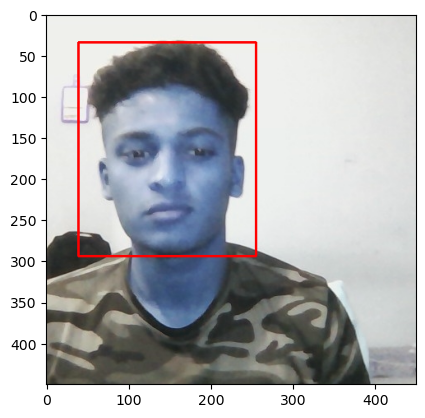

In [22]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

<h2>Build and Run Augmentation Pipeline</h2>

<h3>we have to create a BBox & create albument images & label them as face present or not present</h3>

In [23]:
def albumentation_pipeline():
    for partition in ['train','test','val']: 
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))

            coords = [0,0,0.00001,0.00001]
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [640,480,640,480]))

            try: 
                for x in range(60):#60 extra samples for each img
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('augment_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                    #now create label for that file
                    annotation = {}
                    annotation['image'] = image
                    #try creating same file as already created file then to merge the file with existing data

                    if os.path.exists(label_path):
                        if len(augmented['bboxes']) == 0: 
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = 0 
                            #int label for training the model 1/0
                        else: 
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 


                    os.makedirs(os.path.join('augment_data', partition, 'labels'), exist_ok=True)
                    os.makedirs(os.path.join('augment_data', partition, 'images'), exist_ok=True)

                    with open(os.path.join('augment_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'),'w') as f:
                        json.dump(annotation,f)

            except Exception as e:
                print(e)

In [25]:
#albumentation_pipeline() 
#call the func when you need to augment the images

<h2>Load Augmented Images to Tensorflow Dataset</h2>

In [24]:
train_images = tf.data.Dataset.list_files('augment_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: x/255)

In [25]:
train_images

<MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None)>

In [26]:
test_images = tf.data.Dataset.list_files('augment_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: x/255)

In [27]:
val_images = tf.data.Dataset.list_files('augment_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: x/255)

In [28]:
train_images.as_numpy_iterator().next()

array([[[0.65882355, 0.654902  , 0.64705884],
        [0.6666667 , 0.6627451 , 0.654902  ],
        [0.6784314 , 0.6627451 , 0.65882355],
        ...,
        [0.16470589, 0.1882353 , 0.17254902],
        [0.1764706 , 0.2       , 0.19215687],
        [0.17254902, 0.20784314, 0.19607843]],

       [[0.64705884, 0.6431373 , 0.63529414],
        [0.6509804 , 0.64705884, 0.6392157 ],
        [0.65882355, 0.6431373 , 0.6392157 ],
        ...,
        [0.16862746, 0.19215687, 0.1764706 ],
        [0.1764706 , 0.2       , 0.19215687],
        [0.1764706 , 0.21176471, 0.2       ]],

       [[0.6392157 , 0.63529414, 0.627451  ],
        [0.6392157 , 0.63529414, 0.627451  ],
        [0.6431373 , 0.627451  , 0.6156863 ],
        ...,
        [0.1764706 , 0.2       , 0.18431373],
        [0.18431373, 0.20784314, 0.19215687],
        [0.18039216, 0.21568628, 0.19607843]],

       ...,

       [[0.8509804 , 0.85882354, 0.85490197],
        [0.8509804 , 0.85882354, 0.85490197],
        [0.8509804 , 0

<h2>explainations in coda notebook under proj</h2>

<h3>Prepare Labels tensor</h3>

In [29]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [30]:
train_labels = tf.data.Dataset.list_files('augment_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [31]:
train_labels.as_numpy_iterator().next()
#array of class then array of BBOxes

(array([1], dtype=uint8),
 array([0.381 , 0.2595, 0.8525, 0.813 ], dtype=float16))

In [32]:
test_labels = tf.data.Dataset.list_files('augment_data\\test\\labels\\*.json', shuffle=False)
test_labels =test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [33]:
val_labels = tf.data.Dataset.list_files('augment_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:

train_images = train_images.map(lambda x: (tf.image.resize(x, (120, 120))))
val_images   = val_images.map(lambda x: (tf.image.resize(x, (120, 120))))
test_images =test_images.map(lambda x: (tf.image.resize(x, (120, 120))))

In [35]:
train_images

<MapDataset element_spec=TensorSpec(shape=(120, 120, None), dtype=tf.float32, name=None)>

<h2>Combine Label and Image Samples</h2>

In [36]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2820, 2820, 300, 300, 360, 360)

In [37]:
train=tf.data.Dataset.zip((train_images,train_labels))
train.shuffle(5000)
train=train.batch(batch_size=8)
train=train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
len(train)#batch of 8

353

In [39]:
train.as_numpy_iterator().next()

(array([[[[0.6489583 , 0.640625  , 0.6331495 ],
          [0.6276348 , 0.61194855, 0.60447305],
          [0.6544118 , 0.6387255 , 0.6269608 ],
          ...,
          [0.19754902, 0.19754902, 0.18970588],
          [0.19718137, 0.19718137, 0.18933824],
          [0.1764706 , 0.2       , 0.18737745]],
 
         [[0.6272672 , 0.6120711 , 0.599326  ],
          [0.61764705, 0.60588235, 0.58615196],
          [0.6481005 , 0.6353554 , 0.6152574 ],
          ...,
          [0.24117649, 0.24901962, 0.2382353 ],
          [0.23284313, 0.25281864, 0.23731618],
          [0.25796568, 0.30110294, 0.27267158]],
 
         [[0.63982844, 0.6202206 , 0.6015932 ],
          [0.64319855, 0.63143384, 0.60398287],
          [0.6509804 , 0.6313726 , 0.60784316],
          ...,
          [0.2713848 , 0.2879289 , 0.29142156],
          [0.358701  , 0.39681372, 0.39295343],
          [0.41642156, 0.47034314, 0.44779414]],
 
         ...,
 
         [[0.8602941 , 0.8602941 , 0.85245097],
          [0.85839

In [40]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [41]:
train.as_numpy_iterator().next()[0]#images

array([[[[0.6489583 , 0.640625  , 0.6331495 ],
         [0.6276348 , 0.61194855, 0.60447305],
         [0.6544118 , 0.6387255 , 0.6269608 ],
         ...,
         [0.19754902, 0.19754902, 0.18970588],
         [0.19718137, 0.19718137, 0.18933824],
         [0.1764706 , 0.2       , 0.18737745]],

        [[0.6272672 , 0.6120711 , 0.599326  ],
         [0.61764705, 0.60588235, 0.58615196],
         [0.6481005 , 0.6353554 , 0.6152574 ],
         ...,
         [0.24117649, 0.24901962, 0.2382353 ],
         [0.23284313, 0.25281864, 0.23731618],
         [0.25796568, 0.30110294, 0.27267158]],

        [[0.63982844, 0.6202206 , 0.6015932 ],
         [0.64319855, 0.63143384, 0.60398287],
         [0.6509804 , 0.6313726 , 0.60784316],
         ...,
         [0.2713848 , 0.2879289 , 0.29142156],
         [0.358701  , 0.39681372, 0.39295343],
         [0.41642156, 0.47034314, 0.44779414]],

        ...,

        [[0.8602941 , 0.8602941 , 0.85245097],
         [0.8583946 , 0.8583946 , 0.8505515 ]

In [42]:
train.as_numpy_iterator().next()[1]#labeles-> {class,points}

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.381 , 0.2595, 0.8525, 0.813 ],
        [0.4478, 0.2727, 0.919 , 0.826 ],
        [0.4456, 0.2283, 0.917 , 0.7817],
        [0.4766, 0.264 , 0.9478, 0.8174],
        [0.561 , 0.1959, 1.    , 0.7495],
        [0.1943, 0.2115, 0.6655, 0.765 ],
        [0.512 , 0.2527, 0.9834, 0.806 ],
        [0.2566, 0.207 , 0.728 , 0.7607]], dtype=float16))

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [45]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
len(res[0])
#res->((batch_images),(batch_labels))

8

In [46]:
res[0]# 8images

array([[[[0.6489583 , 0.640625  , 0.6331495 ],
         [0.6276348 , 0.61194855, 0.60447305],
         [0.6544118 , 0.6387255 , 0.6269608 ],
         ...,
         [0.19754902, 0.19754902, 0.18970588],
         [0.19718137, 0.19718137, 0.18933824],
         [0.1764706 , 0.2       , 0.18737745]],

        [[0.6272672 , 0.6120711 , 0.599326  ],
         [0.61764705, 0.60588235, 0.58615196],
         [0.6481005 , 0.6353554 , 0.6152574 ],
         ...,
         [0.24117649, 0.24901962, 0.2382353 ],
         [0.23284313, 0.25281864, 0.23731618],
         [0.25796568, 0.30110294, 0.27267158]],

        [[0.63982844, 0.6202206 , 0.6015932 ],
         [0.64319855, 0.63143384, 0.60398287],
         [0.6509804 , 0.6313726 , 0.60784316],
         ...,
         [0.2713848 , 0.2879289 , 0.29142156],
         [0.358701  , 0.39681372, 0.39295343],
         [0.41642156, 0.47034314, 0.44779414]],

        ...,

        [[0.8602941 , 0.8602941 , 0.85245097],
         [0.8583946 , 0.8583946 , 0.8505515 ]

In [47]:
res[1][1]

array([[0.381 , 0.2595, 0.8525, 0.813 ],
       [0.4478, 0.2727, 0.919 , 0.826 ],
       [0.4456, 0.2283, 0.917 , 0.7817],
       [0.4766, 0.264 , 0.9478, 0.8174],
       [0.561 , 0.1959, 1.    , 0.7495],
       [0.1943, 0.2115, 0.6655, 0.765 ],
       [0.512 , 0.2527, 0.9834, 0.806 ],
       [0.2566, 0.207 , 0.728 , 0.7607]], dtype=float16)

In [48]:
sample_img=res[0]

In [49]:
print_img=res[0][5]
print_labels=res[1][1][5]
print(print_img)
print("\n labels=",print_labels)


[[[0.9411765  0.88235295 0.9647059 ]
  [0.9411765  0.88235295 0.9647059 ]
  [0.9411765  0.88235295 0.9647059 ]
  ...
  [0.8663603  0.8075368  0.8820466 ]
  [0.8666667  0.80784315 0.88235295]
  [0.86066175 0.8018382  0.88125   ]]

 [[0.9372549  0.8862745  0.9647059 ]
  [0.9372549  0.8862745  0.9647059 ]
  [0.9372549  0.8862745  0.9647059 ]
  ...
  [0.8622549  0.8034314  0.8857843 ]
  [0.85925245 0.8004289  0.87677693]
  [0.8609682  0.80214465 0.88192403]]

 [[0.9372549  0.8862745  0.9647059 ]
  [0.9372549  0.8862745  0.9647059 ]
  [0.9372549  0.8862745  0.9647059 ]
  ...
  [0.85968137 0.80085784 0.8832108 ]
  [0.8656863  0.8068628  0.8892157 ]
  [0.8666667  0.80784315 0.8901961 ]]

 ...

 [[0.55631125 0.5004289  0.620527  ]
  [0.49166667 0.48578432 0.5785539 ]
  [0.42107844 0.4449755  0.5298407 ]
  ...
  [0.6911765  0.59705883 0.6598039 ]
  [0.6931373  0.60379905 0.6729779 ]
  [0.6870098  0.6101716  0.6750613 ]]

 [[0.5334559  0.5001838  0.595098  ]
  [0.452451   0.44908088 0.52107847]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


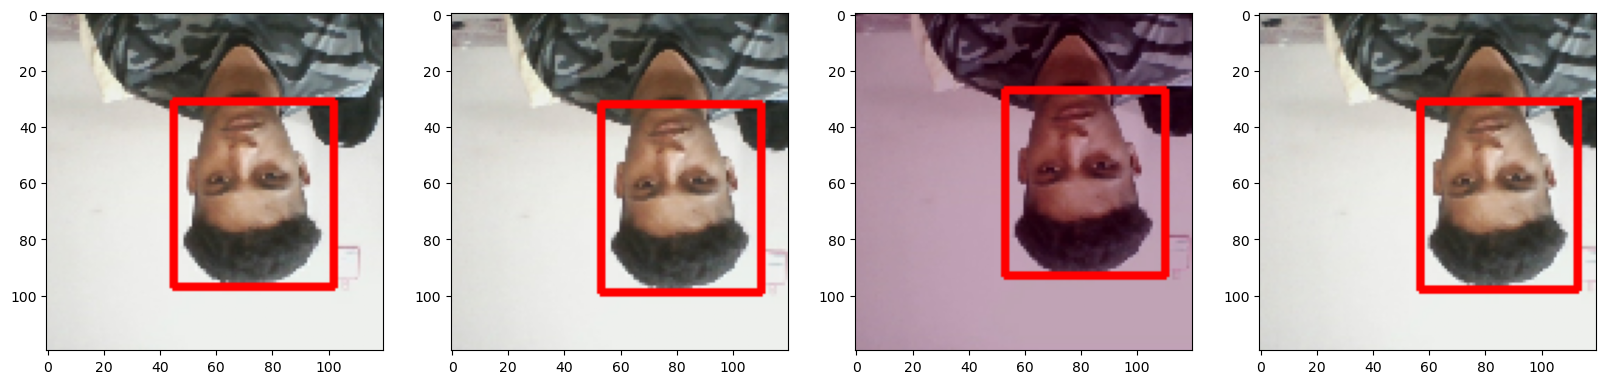

In [50]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_img = res[0][idx].copy()
    sample_coords=res[1][1][idx].copy()
    sample_img.setflags(write=True)
    
    cv2.rectangle(
        sample_img,
        tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
        tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
        (255,0,0),
        2
    )
    ax[idx].imshow(sample_img)

<h1>Build Deep Learning using the Functional API</h1>

In [51]:
from tensorflow.keras.applications import VGG16

In [52]:
vgg=VGG16(include_top=False)
#to exclude the default dense/output layer of model

In [59]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<h2> Need to build a functional model instead of sequential model <br>since we need two types of output [face(yes/no),Bbox_params]</h2>

In [65]:
def build_model():
    input_layer=tf.keras.layers.Input(shape=(120,120,3),name="input_layer")
    
    vgg=VGG16(include_top=False)(input_layer)
    
    #classification
    f1=tf.keras.layers.GlobalMaxPooling2D(name='poolingf1')(vgg)
    
    classi_lay1=tf.keras.layers.Dense(2048,activation='relu',name="classi1")(f1)
    classi_lay2=tf.keras.layers.Dense(1,activation='sigmoid',name="classi2")(classi_lay1)
    
    #Bbox model
    f2=tf.keras.layers.GlobalMaxPooling2D(name='poolingf2')(vgg)
    
    reg_lay1=tf.keras.layers.Dense(2048,activation='relu',name="regress1")(f2)
    reg_lay2=tf.keras.layers.Dense(4,activation='sigmoid',name="regress2")(reg_lay1)
    
    model=tf.keras.Model(inputs=input_layer,outputs=[classi_lay2,reg_lay2])
    return model

In [66]:
facetracker=build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_layer[0][0]']            
                                512)                                                              
                                                                                                  
 poolingf1 (GlobalMaxPooling2D)  (None, 512)         0           ['vgg16[0][0]']                  
                                                                                            

<h2>test for predict of base layer</h2>

In [55]:
b=train.as_numpy_iterator().next()
x,y=b

x.shape

(8, 120, 120, 3)

In [56]:
classes,coords=facetracker.predict(x)
classes,coords

1/1 [==============================] - 9s 9s/step


(array([[0.64705884],
        [0.64788026],
        [0.6477208 ],
        [0.7000541 ],
        [0.4709816 ],
        [0.4777287 ],
        [0.6702033 ],
        [0.4678378 ]], dtype=float32),
 array([[0.35797206, 0.5218718 , 0.37478185, 0.50853497],
        [0.36912656, 0.5344233 , 0.39271703, 0.50226057],
        [0.40349248, 0.5730503 , 0.41031885, 0.51136196],
        [0.33956927, 0.522633  , 0.4176493 , 0.4876068 ],
        [0.42436633, 0.44949052, 0.448182  , 0.43310884],
        [0.48882782, 0.46997172, 0.41447988, 0.40904102],
        [0.3512792 , 0.53807753, 0.41935903, 0.5023998 ],
        [0.5154898 , 0.49002862, 0.3939621 , 0.4154517 ]], dtype=float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


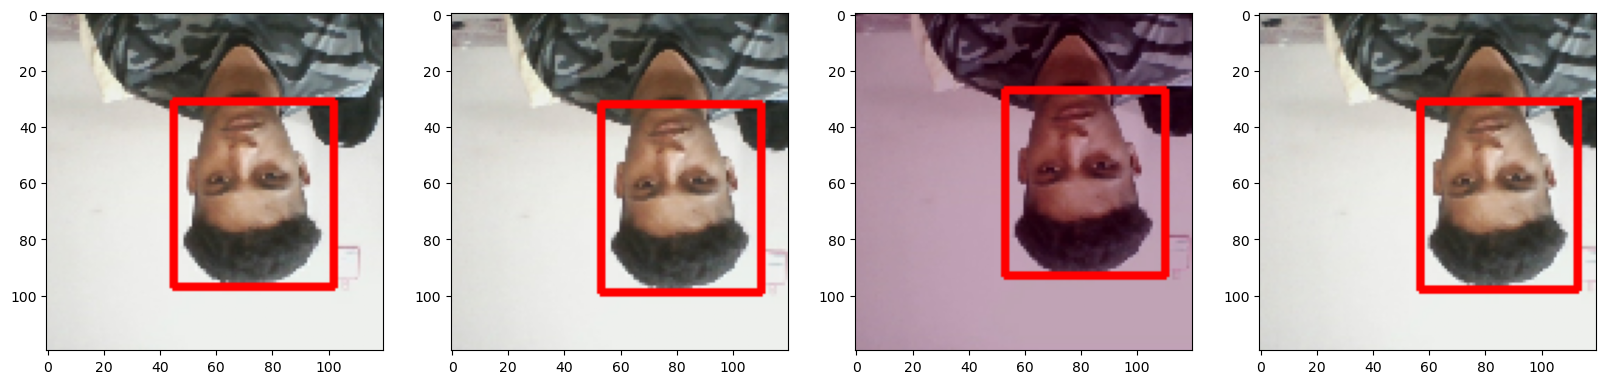

In [57]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_img = b[0][idx].copy()
    sample_coords=b[1][1][idx].copy()
    sample_img.setflags(write=True)
    
    cv2.rectangle(
        sample_img,
        tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
        tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
        (255,0,0),
        2
    )
    ax[idx].imshow(sample_img)

<h1>Define custom Losses and Optimizers</h1>

In [58]:
classloss = tf.keras.losses.BinaryCrossentropy()


In [ ]:
#regressloss = tf.keras.losses.MeanSquaredError()


In [59]:
def localization_loss(y_true, y_pred):
    # Coordinate differences
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))
    
    # Height and width differences
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = y_pred[:, 3] - y_pred[:, 1]
    w_pred = y_pred[:, 2] - y_pred[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

regressloss = localization_loss


In [76]:
facetracker.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "classi2":tf.keras.losses.BinaryCrossentropy(),  # Classification output
        "regress2": localization_loss  # Regression output
    },
    loss_weights={
        "classi2": 0.5,  # Weight for classification loss
        "regress2": 1.0   # Weight for regression loss
    },
    metrics={
        "classi2": ["accuracy"],  # Accuracy for classification
        "regress2": []             # No metrics for regression
    }
)


In [81]:
y.values

<function dict.values>

In [82]:
train = train.map(lambda x, y: (tf.ensure_shape(x, [None, 120, 120, 3]),
                                {"classi2": tf.ensure_shape(y["classification_output"], [None, 1]),
                                 "regress2": tf.ensure_shape(y["regression_output"], [None, 4])}))


In [84]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
history = facetracker.fit(train, epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
353/353 [==============================] - 89s 251ms/step - loss: 1.1688 - classi2_loss: 0.5630 - regress2_loss: 0.8873 - classi2_accuracy: 0.9216 - val_loss: 1.4129 - val_classi2_loss: 0.1945 - val_regress2_loss: 1.3156 - val_classi2_accuracy: 0.9694
Epoch 2/20
353/353 [==============================] - 31s 89ms/step - loss: 1.1461 - classi2_loss: 0.4128 - regress2_loss: 0.9397 - classi2_accuracy: 0.9273 - val_loss: 1.3142 - val_classi2_loss: 0.1675 - val_regress2_loss: 1.2304 - val_classi2_accuracy: 0.9694
Epoch 3/20
353/353 [==============================] - 30s 85ms/step - loss: 1.0867 - classi2_loss: 0.3254 - regress2_loss: 0.9240 - classi2_accuracy: 0.9124 - val_loss: 1.5520 - val_classi2_loss: 0.1759 - val_regress2_loss: 1.4640 - val_classi2_accuracy: 0.9694
Epoch 4/20
353/353 [==============================] - 30s 85ms/step - loss: 1.2111 - classi2_loss: 0.3148 - regress2_loss: 1.0537 - classi2_accuracy: 0.9043 - val_loss: 1.1443 - val_classi2_loss: 0.1657 - val_regr

In [87]:
history.history

{'loss': [1.168831467628479,
  1.1460922956466675,
  1.0866618156433105,
  1.2110989093780518,
  1.108234167098999,
  1.1259089708328247,
  1.0780518054962158,
  0.9580058455467224,
  0.8165557384490967,
  0.9798986315727234,
  0.8061209321022034,
  0.6661878824234009,
  0.48140838742256165,
  0.3831704556941986,
  0.37949901819229126,
  0.3595343232154846,
  0.3237709403038025,
  0.23982171714305878,
  0.2860625684261322,
  0.21031251549720764],
 'classi2_loss': [0.5630070567131042,
  0.41284531354904175,
  0.3253938853740692,
  0.3148190379142761,
  0.22868621349334717,
  0.2561086118221283,
  0.35896894335746765,
  0.30921220779418945,
  0.21595114469528198,
  0.2136886864900589,
  0.20824070274829865,
  0.14614003896713257,
  0.11475204676389694,
  0.08052022755146027,
  0.08405982702970505,
  0.08247629553079605,
  0.0619729608297348,
  0.03610847517848015,
  0.05386078730225563,
  0.034669630229473114],
 'regress2_loss': [0.8873279690742493,
  0.9396699666976929,
  0.923965156078

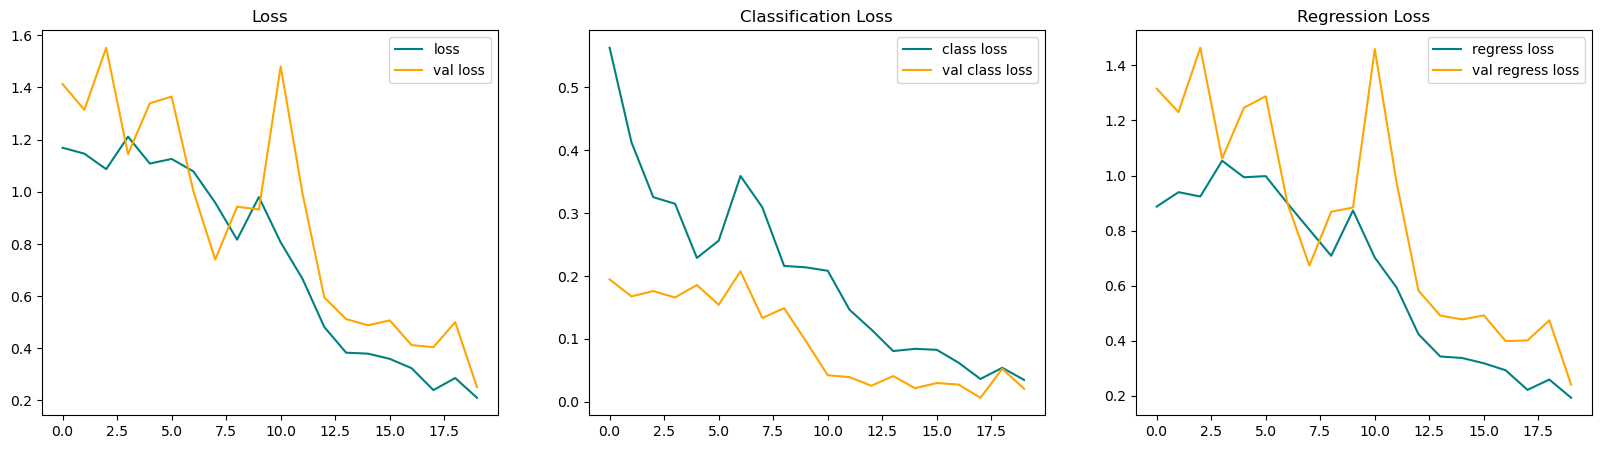

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['loss'], color='teal', label='loss')
ax[0].plot(history.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classi2_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classi2_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress2_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regress2_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

###  Make Predictions on Test Set

In [91]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


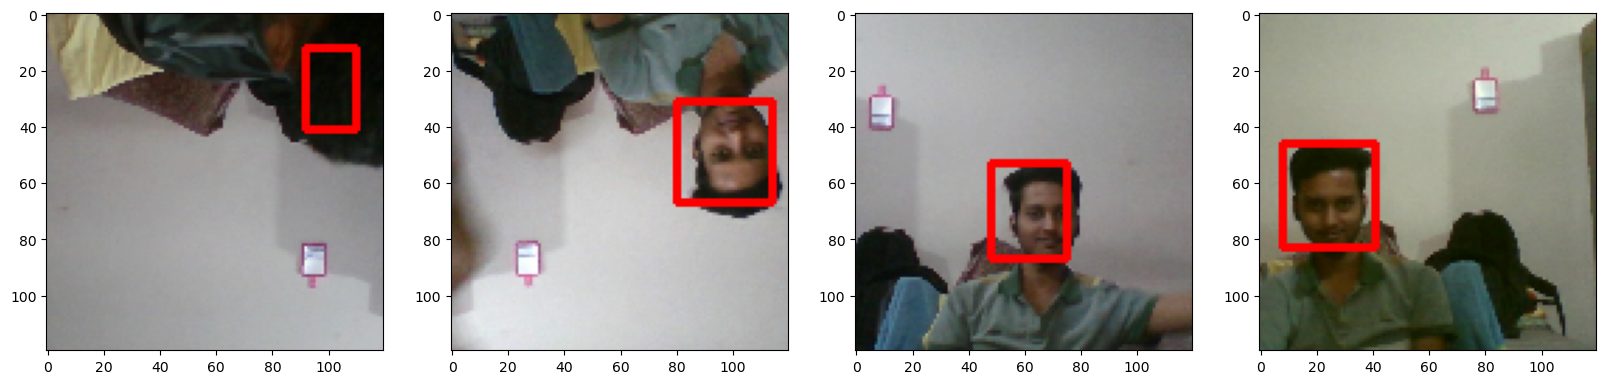

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    
    sample_img = test_sample[0][idx].copy()
    sample_coords=yhat[1][idx].copy()
    sample_img.setflags(write=True)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_img, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_img)

In [94]:
from tensorflow.keras.models import load_model

In [104]:
facetracker.save('facetracker.h5')

<h1>Real time detection</h1>

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    _,frame=cap.read()
    frame=frame[50:500,50:500,:]#we need 450*450px
    
    rgb=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    resized=tf.image.resize(rgb,(120,120))
    
    y_pred=facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords=y_pred[1][0]
    
    if y_pred[0]>0.5:
        
        cv2.rectangle(frame,
            tuple(np.multiply(sample_coords[:2],[450,450]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
            (255,0,0), 2
        )
        cv2.rectangle(frame, 
            tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                [0,-30])),
            tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                [80,0])), 
            (255,0,0), -1
        )
        
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
            [0,-5])),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
        )
        
    cv2.imshow('EyeTrack',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 

In [103]:
cap.release()
cv2.destroyAllWindows()